# HDA - Project 3

In [2]:
import utils
import deeplearning
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from keras import regularizers
from keras.activations import relu
from keras.layers import Conv2D, BatchNormalization, Dropout, LeakyReLU, Flatten, Activation, Dense, MaxPooling2D, LSTM, Reshape
from keras.models import load_model, Model, Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


The following cell contains the hyper-parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: column of features to be selected to perform activity detection, between [0,6]:

|  Label |  Feature |
|:-:     |:-:|
|  0     | Locomotion (TASK A)  |
|  1     | High Level Activity |
|  2     | Low Level Left Arm  |
|  3     | Low Level Left Arm Object  |
|  4     | Low Level Right Arm  |
|  5     | Low Level Right Arm Object  |
|  6     | Medium Level Both Arms (TASK B2) |

- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

The size of the temporal window seems to be fundamental in order to get a more specific and powerful model; of course the choice of the step lenght between consequent windows has to be consistent and to make sense. Thinking about a real-time situation, as long as we collect data we can use a sliding window of real-time samples; in this way, it is reasonable to use also a small value for the stride. Another important reason behind the choice of the value of the 

In [1]:
subject = 2
folder = "./data/full/"
#folder = "/floyd/input/hdadataset/full/" # To be used with FloydHub
label = 0     # default for task A
window_size = 64
stride = 3

# Detection

The following section consists on the first part of the structure; our idea is to treat separately the detection of the movement (i.e. the _null class_) and the movement classication itself.

The steps that we take are the following: first we set all the labels different from 0 to 1, making the problem binary; then, we build a suitable network that can spot the movement.

In [3]:
[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(subject,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    make_binary = True)

Training samples:  145808 
Test samples:       57720 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (48581, 64, 110) 
Dataset of Labels have shape:    (48581, 2) 
Fraction of labels:   [0.0901587 0.9098413]
TEST SET:
Dataset of Images have shape:  (19219, 64, 110) 
Dataset of Labels have shape:    (19219, 2) 
Fraction of labels:   [0.15984182 0.84015818]


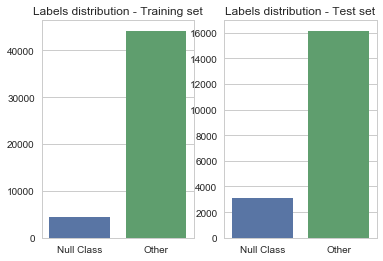

In [4]:
# plot of the labels distribution for this user (might be useful)

sns.set(style="whitegrid")

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x_classes = ['Null Class','Other']
y_values = np.sum(y_train, axis = 0)
sns.barplot(x=x_classes, y=y_values, ax=ax1).set_title('Labels distribution - Training set')

y_values = np.sum(y_test, axis = 0)
sns.barplot(x=x_classes, y=y_values, ax=ax2).set_title('Labels distribution - Test set')

### Model Definition

In [5]:
def MotionDetection(input_shape, classes, withSoftmax = True):
    
    model = Sequential()
  
    # Layer 0
    model.add(BatchNormalization(input_shape = input_shape))

    # Layer 1
    model.add(Conv2D(filters = 50,
                    kernel_size = (11,3),
                    strides=(1,1),
                    activation='relu'))
    
    # Layer 2
    model.add(MaxPooling2D(pool_size=(2,1)))
    
    # Layer 3
    # This layer dimension are automatically scanned in order to avoid updating by hand each time
    model.add(Reshape((model.layers[2].output_shape[1],model.layers[2].output_shape[2] * model.layers[2].output_shape[3])))  

    # Layer 4
    model.add(LSTM(20,
                  return_sequences=True))
    
    # Layer 5 
    model.add(LSTM(20))
   
    # Layer 6
    model.add(Dense(512,activation = 'relu'))
    
    if (withSoftmax):
        # Layer 7
        model.add(Dense(classes, activation = 'softmax'))
    
    return model

### Model compilation and input reshaping

In [6]:
n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 2

input_train = x_train.reshape(x_train.shape[0], window_size, n_features, 1)
input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

#switch to markdown if model is already trained and it just need to be loaded
detection_model = MotionDetection((window_size,n_features,1), n_classes)
detection_model.summary() # model visualization

detection_model.compile(optimizer = Adam(lr=0.01), 
                   loss = "categorical_crossentropy", 
                   metrics = ["accuracy"])

### Model fitting

After the training procedure, the model will be saved on the local disk.

#switch to markdown if model is already trained and it just need to be loaded
detection_model.fit(x = input_train, 
               y = y_train, 
               epochs = 20, 
               batch_size = 300,
               verbose = 1,
               validation_data=(input_test, y_test))

detection_model.save('./detection_model.h5')
detection_model.save_weights('./detection_model_weights.h5')

In [7]:
detection_model = load_model('./data/detection_model.h5')

### Performance evaluation

In [8]:
output_test = detection_model.predict(input_test)
prediction = np.argmax(output_test, axis=1)

Accuracy:  0.8230917321400697
F1-measure:  0.843380473571203


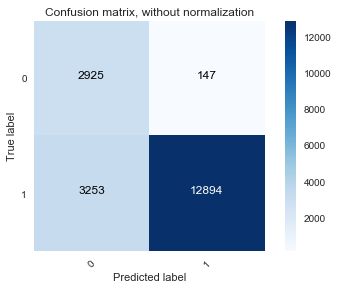

In [9]:
print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Classification

After the _detection_ step we import and preprocess again the dataset, this time excluding all the samples associated to the _null class_; in this way we could build a neural network cleaned of the null class and that can distinguish better the difference between motions.

In [14]:
[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(subject,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    null_class = False)

Training samples:  157125 
Test samples:       57536 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (46601, 64, 110) 
Dataset of Labels have shape:    (46601, 4) 
Fraction of labels:   [0.47 0.31 0.19 0.03]
TEST SET:
Dataset of Images have shape:  (15758, 64, 110) 
Dataset of Labels have shape:    (15758, 4) 
Fraction of labels:   [0.42 0.25 0.29 0.05]


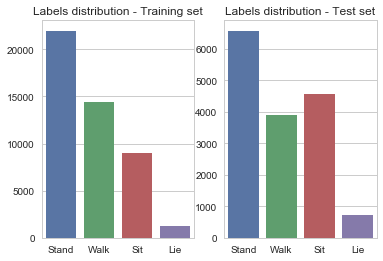

In [15]:
# plot of the labels distribution for this user (might be useful)

sns.set(style="whitegrid")

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x_classes = ['Stand','Walk','Sit','Lie']
y_values = np.sum(y_train, axis = 0)
sns.barplot(x=x_classes, y=y_values, ax=ax1).set_title('Labels distribution - Training set')

y_values = np.sum(y_test, axis = 0)
sns.barplot(x=x_classes, y=y_values, ax=ax2).set_title('Labels distribution - Test set')

### Model definition, compilation and input reshaping

In [16]:
n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 4

input_train = x_train.reshape(x_train.shape[0], window_size, n_features, 1)
input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

#switch to markdown if model is already trained and it just need to be loaded
classification_model = deeplearning.Hybrid((window_size,n_features,1), n_classes)
classification_model.summary() # model visualization

classification_model.compile(optimizer = Adam(lr=0.01), 
                   loss = "categorical_crossentropy", 
                   metrics = ["accuracy"])

### Model fitting

After the training procedure, the model will be saved on disk

#switch to markdown if model is already trained and it just need to be loaded
classification_model.fit(x = input_train, 
               y = y_train, 
               epochs = 20, 
               batch_size = 300,
               verbose = 1,
               validation_data=(input_test, y_test))

classification_model.save('./detection_model.h5')
classification_model.save_weights('./detection_model_weights.h5')

In [17]:
classification_model = load_model('./data/classification_model.h5')

In [19]:
output_test = classification_model.predict(input_test)
prediction = np.argmax(output_test, axis=1)

Accuracy:  0.9408554385074248
F1-measure:  0.940605458245886


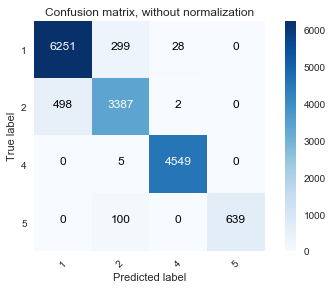

In [21]:
print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')